### These are the key components that will be utilized throughout the project:
- ###Components  utilized for the project:
- TypedDict function to define and manage the state of each customer interaction (State management)
- Classification of customer queries into technical, billing or general queries (Queries Categorization)
- Determining the emotional tone of each customer's query under sentiment analysis
- Generating appropriate responses based on the query category and sentiment under response generation
- Automatically escalate queries with a negative sentiment to human agants for further assistance under Escalation mechanism
- LangGraph module used to create a flexible and extensible workflow under Workflow Graph

### The methods followed to ensure the project works
-Setting up the environment and importing the necessary libraries
- Creating a structure that hold query information, category, sentiment and responses under the state definition
- Implementing separate funstions for categorization, sentiment analysis and response generation under the node functions
- Use StateGraph to define the workflow, add nodes and edges to represent the support process under the Graph construction
- Implementing logic to route queries based on their category and sentiment (conditional routing)
- Compile the graph into an executable application under the Workflow compilation 
-Process the customer queries through a workflow and retrieve the results


In [1]:
# !pip install langgraph
# !pip install python-dotenv

In [2]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import HumanMessagePromptTemplate, ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_groq import ChatGroq
from IPython.display import display, Image
from dotenv import load_dotenv
import os

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the api keys
load_dotenv()
groq_api_key = os.getenv("groq_api_key")
# Check if API key loaded successfully
if groq_api_key:
    print("Groq API key loaded successfully")
else:
    print("Error: Groq API key not found. Check your .env file")

Groq API key loaded successfully


## Define the State structure

In [4]:
# Create the state class
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

In [5]:
# Define the Large Language Model
LLM = ChatGroq(
    temperature=0,
    groq_api_key = groq_api_key,
    model_name="llama-3.3-70b-versatile"
)

In [6]:
# Test how the model performs
response = LLM.invoke("What is Deep Learning?")
response.content

'**Deep Learning Overview**\n==========================\n\nDeep learning is a subset of machine learning that involves the use of artificial neural networks to analyze and interpret data. These neural networks are designed to mimic the structure and function of the human brain, with multiple layers of interconnected nodes (neurons) that process and transform inputs into meaningful representations.\n\n**Key Characteristics**\n-----------------------\n\n* **Artificial Neural Networks**: Deep learning models are based on artificial neural networks, which are composed of multiple layers of interconnected nodes (neurons) that process and transform inputs.\n* **Multiple Layers**: Deep learning models typically have multiple layers, including input layers, hidden layers, and output layers. Each layer processes and transforms the input data in a specific way.\n* **Non-Linear Transformations**: Deep learning models use non-linear transformations to process and transform the input data, allowing

In [7]:
# Defining the node function
## Categorizing function
def categorize(state : State) -> State:
    "Technical, Billing, General"
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer queries into the following:"
        "Technical, Billing, General. Query: {query}"
    )
    chain = prompt|LLM
    category = chain.invoke({"query" : state['query']}).content
    return {"category": category}

In [8]:
# analyzing the sentiment
def analyze_sentiment(state : State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer queries."
        "Return with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt|LLM
    sentiment = chain.invoke({"query" : state['query']}).content # captures the sentiment
    return {"sentiment": sentiment} # returns the sentiment according to the query

In [9]:
# Define the technical function
def handle_technical(state : State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query : {query}"
    )
    chain = prompt | LLM
    response = chain.invoke({"query" : state['query']}).content # this captures the technical content
    return{"response": response} # this returns the response according to the technical question

In [10]:
# Define the billing function
def handle_billing(state : State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Give out a billing support response to the following query : {query}"
    )
    chain = prompt | LLM
    response = chain.invoke({"query" : state['query']}).content
    return{"response": response}


In [11]:
# General function
def handle_general(state : State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query : {query}"
    )
    chain = prompt|LLM
    response = chain.invoke({"query" : state['query']}).content
    return{"response" : response}

In [12]:
# Function if the query has a negative sentiment
def escalate(state : State) -> State:
    return{"response": "This query has been escalate to a human agent due to its negative sentiment"}

In [13]:
# Handle the routing function
def route_query(state : State) -> State:
    if state["sentiment"] == ["Negative"]:
        return "escalate"
    elif state['category'] == ['Technical']:
        return 'handle_technical'
    elif state['category'] == ['Billing']:
        return 'handle_billing'
    else:
        return 'handle_general'

### Create a workflow in form of graph

In [14]:
# Build the workflow
workflow = StateGraph(State)
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

In [15]:
# Add edges
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges("analyze_sentiment", route_query,
                               {"handle_technical" : "handle_technical",
                                "handle_billing" : "handle_billing",
                                "handle_general" : "handle_general",
                                "escalate" : "escalate"})
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

In [16]:
# Add the entry point
workflow.set_entry_point("categorize")

In [17]:
# Compile the workflow
app = workflow.compile()

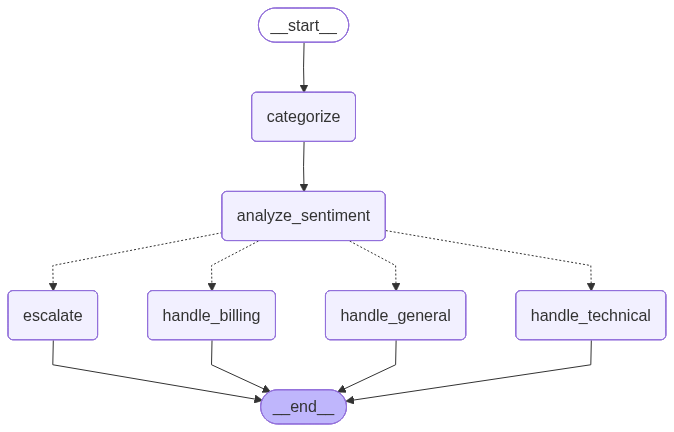

In [18]:
# Draw the graph
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

### Customer Support function

In [19]:
# function to run the customer support
def run_customer_support(query : str) -> dict:
    result = app.invoke({"query": query})
    return{
        "category" : result['category'],
        "sentiment" : result['sentiment'],
        "response" : result['response'],
    }

In [20]:
# Test the performance of the output
query = "I am having a problem making payment, how can you help me?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: I am having a problem making payment, how can you help me?
Category: The customer query "I am having a problem making payment, how can you help me?" would be categorized as: Billing.
Sentiment: Neutral. 

The customer is experiencing an issue, but the tone is not angry or frustrated, and they are seeking help, which indicates a neutral sentiment. They are not expressing dissatisfaction or complaint, but rather seeking assistance to resolve the problem.
Response: I'm so sorry to hear that you're having trouble making a payment. I'm here to help you resolve the issue as quickly as possible. Can you please provide me with more details about the problem you're experiencing, such as the error message you're seeing or the specific step where you're getting stuck? This will help me better understand the issue and provide a more accurate solution.

In the meantime, I can offer some general troubleshooting steps that may help. Have you tried checking your account balance, verifying your 